In [3]:
import random
import torch
import torch.optim as optim
import torch.nn as nn
from typing import List, Tuple, Union, Optional, Any
from connect_4_env import ConnectFourEnv
from tqdm import tqdm
import math
import torch.nn.functional as F
from replay_buffer import ReplayBuffer
from monte_carlo_agent import MonteCarloTreeSearchAgent 
from agent import RandomAgent, Agent
from human_agent import HumanAgent
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard.writer import SummaryWriter



In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [9]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.conv = nn.Conv2d(1, 128, kernel_size=4, stride=1, padding=0)
        self.fc1 = nn.Linear(128 * (input_shape[0] - 3) * (input_shape[1] - 3), 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, num_actions)

    def forward(self, x):
        x = x.view(-1, 1, self.input_shape[0], self.input_shape[1])
        x = F.relu(self.conv(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

class DQNAgent(Agent):
    def __init__(self, env, replay_buffer, evaluation_agent=None):
        super().__init__(env)
        self.name = "DQNAgent"
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.n
        self.replay_buffer: ReplayBuffer = replay_buffer
        self.policy_net = DQN(self.state_dim, self.action_dim).to(device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Target net is not trained
        self.lr = 0.01
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        # self.lr_scheduler = lr_scheduler.ExponentialLR(optimizer=self.optimizer, gamma=0.99)
        self.lr_scheduler = None
        self.steps_done = 0
        self.epsilon_start = 0.9
        self.epsilon_end = 0.05 # if you leave overnight, you can decrease this to 0.01
        self.epsilon_decay = 5_000_000 # if you leave overnight, you can increase this to 1_000_000
        self.batch_size = 256
        self.gamma = 0.99  # Discount factor
        self.target_update = 5000
        self.loss = nn.MSELoss()
        if evaluation_agent is None:
            self.evaluation_agent = RandomAgent(self.env)
        else:
            self.evaluation_agent = evaluation_agent

    def load_trained_model_from_file(self, path):
        self.policy_net = torch.load(path)
        self.policy_net.eval()

    def choose_action(self, explore=False) -> int:
        sample = random.random()
        epsilon_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        legal_moves = self.env.get_legal_actions()
        if sample > epsilon_threshold or not explore:
            with torch.no_grad():
                state_tensor = torch.tensor(
                    self.env.board, dtype=torch.float).to(device).unsqueeze(0)
  
                predictions = self.policy_net(state_tensor)
                
                # Mask out illegal moves
                for i in range(self.env.action_space.n):
                    if i not in legal_moves:
                        predictions[0][i] = -float('inf')

                # Choose the action with the highest Q value that is legal and convert to int
                best_action = int(torch.argmax(predictions).item())
                return best_action
        else:
            return random.choice(legal_moves)

    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size)

        # Calculate current Q-values from the policy_net
        current_q_values = self.policy_net(states).gather(1, actions).squeeze(-1)
        next_state_values = self.target_net(next_states).max(1)[0]

        # Compute the expected Q values for the current state-action pairs
        expected_q_values = rewards.squeeze(-1) + \
                        self.gamma * next_state_values * (1 - dones.squeeze(-1).float())

        # Compute loss
        loss = self.loss(current_q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        writer.add_scalar("Loss", loss.item(), self.steps_done)
        

        return loss.item()

    def train(self, n_games, print_interval):
        losses = []

        self.evaluate(50, message=True)

        for episode in tqdm(range(n_games)):
            observation = self.env.reset()
            done = False

            while not done:
                action = self.choose_action(explore=True)
                self.steps_done += 1

                next_observation, reward, done, info = self.env.step(action)
                self.replay_buffer.push(
                    observation, action, reward, next_observation, done)
                
                # the agent thinks he is player 1, so we need to flip the board and the player
                self.env.flip_board()
                self.env.current_player = 3 - self.env.current_player

                loss = self.optimize_model()

                observation = next_observation

                if loss is not None:
                    losses.append(loss)

            if (episode + 1) % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            if (episode + 1) % print_interval == 0 and len(losses) > 0:
                avg_win_rate = sum(losses[-print_interval:]) / len(losses[-print_interval:])
                print(f"Episode {episode + 1}: Average Win Rate = {avg_win_rate}")
                
                self.evaluate(50, message=True)
                print()
                torch.save(self.policy_net, f"checkpoints/model_{episode + 1}.pt")
               

    def evaluate(self, n_games, show=False, message=False, evaluation_agent=None):
        if evaluation_agent is None:
            evaluation_agent = self.evaluation_agent

        wins, avg_length, bug = self.env.play(self, evaluation_agent, n_games, show)
        if bug:
            return
        writer.add_scalar("Average Win Rate", wins[1] / n_games * 100, self.steps_done)
        writer.add_scalar("Average Game Length", avg_length, self.steps_done)
        if message:
            print(f"Out of {n_games} games against {evaluation_agent.name}, the model won {wins[1]} games : {wins[1] / n_games * 100:.2f}% with an average game length of {avg_length}")
        return wins

In [19]:
env = ConnectFourEnv()
monte10 = MonteCarloTreeSearchAgent(env, n_iterations=10)
monte50 = MonteCarloTreeSearchAgent(env, n_iterations=50)
monte100 = MonteCarloTreeSearchAgent(env, n_iterations=100)
monte1_000 = MonteCarloTreeSearchAgent(env, n_iterations=1_000)
monte10_000 = MonteCarloTreeSearchAgent(env, n_iterations=10_000)
monte50_000 = MonteCarloTreeSearchAgent(env, n_iterations=50_000)

In [21]:
# Train a new model

replay_buffer = ReplayBuffer(10000, state_shape=env.observation_space.shape, device=device)
agent = DQNAgent(env, replay_buffer, monte50)
# agent.load_trained_model_from_file("checkpoints/model_6000.pt")

# print the number of parameters in the model
print(
    f"Number of parameters in the model: {sum(p.numel() for p in agent.policy_net.parameters())}")

Number of parameters in the model: 105159


100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


Out of 50 games against MCTS-50, the model won 3 games : 6.00% with an average game length of 10.94


  1%|          | 999/120000 [00:54<1:45:00, 18.89it/s]

Episode 1000: Average Win Rate = 0.0247185941869393


  1%|          | 1001/120000 [00:59<22:09:04,  1.49it/s]

Out of 50 games against MCTS-50, the model won 0 games : 0.00% with an average game length of 11.04



  2%|▏         | 1999/120000 [01:53<1:53:28, 17.33it/s] 

Episode 2000: Average Win Rate = 0.030425110436044633


100%|██████████| 50/50 [00:02<00:00, 17.51it/s]


Just as a safeguard, print a game


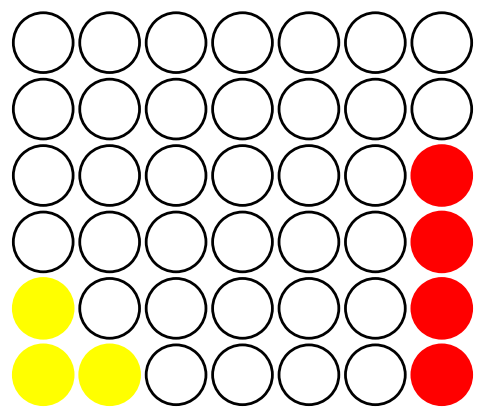

Out of 50 games against MCTS-50, the model won 50 games : 100.00% with an average game length of 8.0



  2%|▏         | 2997/120000 [02:51<1:56:11, 16.78it/s] 

Episode 3000: Average Win Rate = 0.039817782508209346


  3%|▎         | 3002/120000 [02:56<14:12:39,  2.29it/s]

Out of 50 games against MCTS-50, the model won 1 games : 2.00% with an average game length of 10.94



  3%|▎         | 3999/120000 [03:53<2:06:39, 15.27it/s] 

Episode 4000: Average Win Rate = 0.039080291317775843


  3%|▎         | 4001/120000 [03:58<24:42:12,  1.30it/s]

Out of 50 games against MCTS-50, the model won 0 games : 0.00% with an average game length of 11.48



  4%|▍         | 4997/120000 [04:53<1:24:10, 22.77it/s] 

Episode 5000: Average Win Rate = 0.038642442116513846


  4%|▍         | 5003/120000 [04:58<11:51:33,  2.69it/s]

Out of 50 games against MCTS-50, the model won 0 games : 0.00% with an average game length of 11.16



  5%|▍         | 5738/120000 [05:39<1:52:36, 16.91it/s] 


KeyboardInterrupt: 

In [8]:
agent.train(120_000, print_interval=1000)

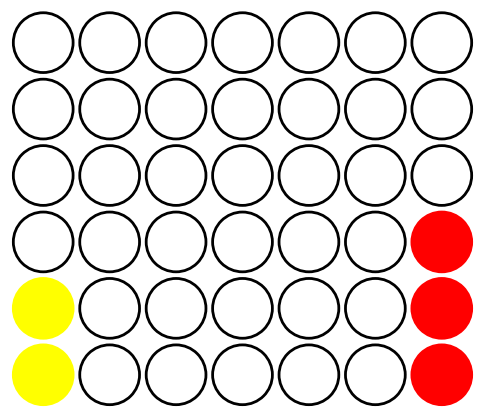

0

In [23]:
test = ConnectFourEnv()
test.step(6)
test.step(0)
test.step(6)
test.step(0)
test.step(6)
test.render()

monte1_000.choose_action()

In [ ]:
!tensorboard --logdir=runs

In [ ]:
env.play(agent, monte50, n_games=10)

In [ ]:
# play against the trained model

env.play(agent, HumanAgent(env), n_games=1, show_game=True, show_outcome=True)

In [ ]:
# save the model
torch.save(agent.policy_net, 'connect_four_model.pt')

In [ ]:
# resume training

env = ConnectFourEnv()
# replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(env, replay_buffer)
agent.policy_net = torch.load('connect_four_model.pt')

In [ ]:
agent.evaluate(1000, message=True)

In [ ]:
# import profilers and check the training bottlenecks of the model

from torch.profiler import profile, ProfilerActivity


with profile(activities=[ProfilerActivity.CUDA, ProfilerActivity.CPU], record_shapes=True) as prof:
    agent.train(50, print_interval=100)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))